<a href="https://colab.research.google.com/github/pulkit48/Satellite-Image-To-Maps-Translation/blob/main/Satellite%20Image%20To%20Maps%20Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import tarfile
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')



Mounted at /content/drive


In [21]:
import tarfile

tar_file_path = "/content/drive/MyDrive/Colab Notebooks/maps.tar.gz"
extract_to_path = "/content/drive/MyDrive/Colab Notebooks"  # Change this to your desired extraction path

# Extract the file
with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(extract_to_path)


# **pix2pix GAN Model**

The whole model is based on the research paper published by Berkeley AI Research (BAIR) Laboratory, UC Berkeley about "Image-to-Image Translation with Conditional Adversarial Networks"

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input,Conv2D,Conv2DTranspose,LeakyReLU,Activation
from keras.layers import Concatenate,Dropout,BatchNormalization
import matplotlib.pyplot as plt
from keras.utils import plot_model

# **Discriminator Model**

In [8]:
# Function to define the discriminator model
def define_discriminator(image_shape):
    # Initialize weights randomly from a normal distribution
    init = RandomNormal(stddev=0.02)

    # Input layers for source and target images
    in_src_image = Input(shape=image_shape)
    in_target_image = Input(shape=image_shape)

    # Concatenate source and target images
    merged = Concatenate()([in_src_image, in_target_image])

    # Convolutional layers with LeakyReLU activation and batch normalization
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Output layer with sigmoid activation
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)

    # Define and compile the model
    model = Model([in_src_image, in_target_image], patch_out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 256, 256, 6)          0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         6208      ['concatenate[0][0]']     

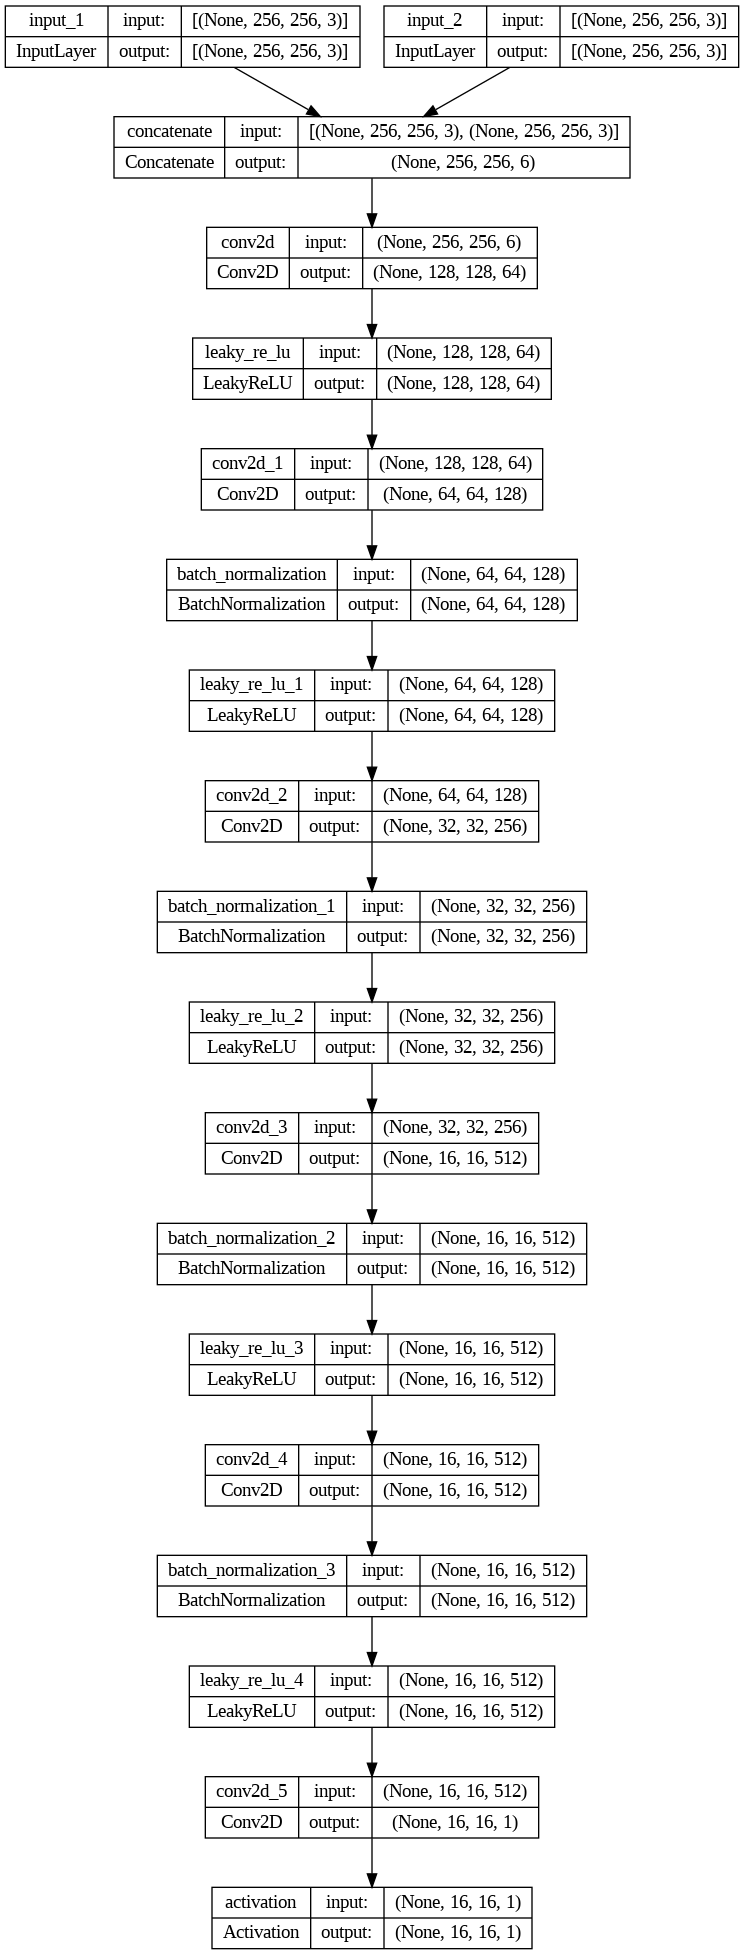

In [9]:
image_shape=(256,256,3)
model=define_discriminator(image_shape)
model.summary()
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

# **Generator Model**

In [10]:
# Function to define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # Initialize weights randomly from a normal distribution
    init = RandomNormal(stddev=0.02)

    # Convolutional layer with LeakyReLU activation and optional batch normalization
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g


In [11]:
# Function to define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # Initialize weights randomly from a normal distribution
    init = RandomNormal(stddev=0.02)

    # Transposed convolutional layer with batch normalization and optional dropout
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

In [12]:
# Function to define the generator model
def define_generator(image_shape=(256,256,3)):
    # Initialize weights randomly from a normal distribution
    init = RandomNormal(stddev=0.02)

    # Input layer for the image
    in_image = Input(shape=image_shape)

    # Encoder blocks
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)

    # Bottleneck layer
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)

    # Decoder blocks
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    # Output layer
    g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)

    # Define and compile the model
    model = Model(in_image, out_image)
    return model

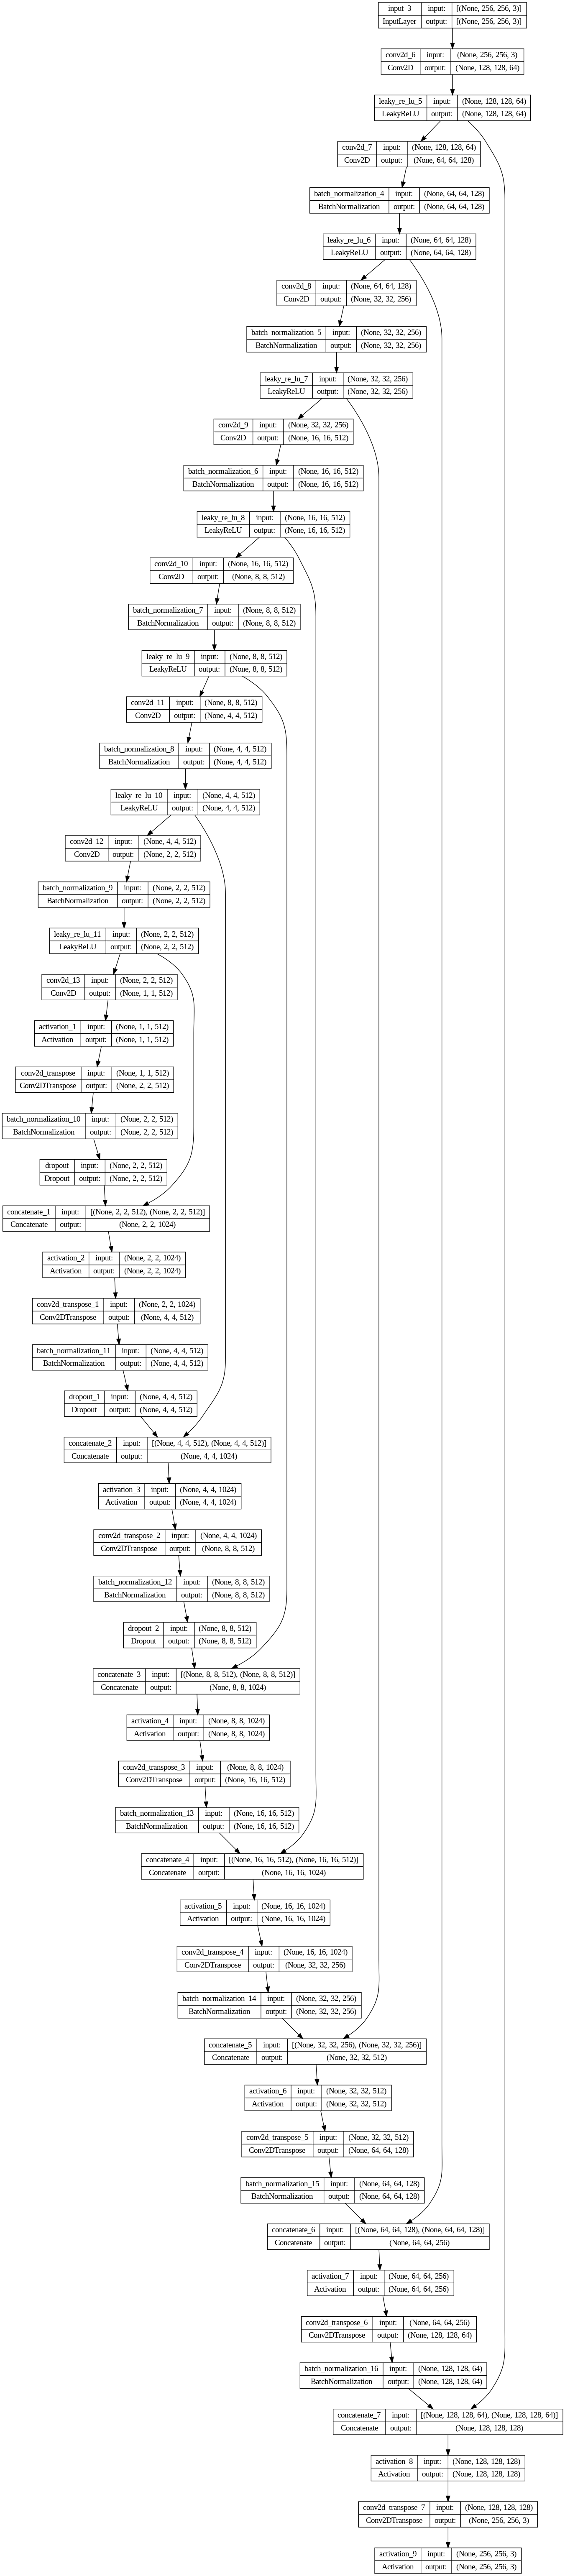

In [13]:
gan_model = define_generator((256,256,3))
plot_model(gan_model, to_file='gen_model.png', show_shapes=True)

In [14]:
# Function to define the combined generator and discriminator model
def define_gan(g_model, d_model, image_shape):
    # Freeze the discriminator layers during GAN training
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False

    # Input layer for the source image
    in_src = Input(shape=image_shape)

    # Generate image from source image
    gen_out = g_model(in_src)

    # Discriminator determines validity of generated images
    dis_out = d_model([in_src, gen_out])

    # Define and compile the GAN model
    model = Model(in_src, [dis_out, gen_out])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [15]:
# load and prepare training images
def load_real_samples(filename):
 # load compressed arrays
 data = load(filename)
 # unpack arrays
 X1, X2 = data['arr_0'], data['arr_1']
 # scale from [0,255] to [-1,1]
 X1 = (X1 - 127.5) / 127.5
 X2 = (X2 - 127.5) / 127.5
 return [X1, X2]

In [16]:
# Function to generate real samples
def generate_real_samples(dataset, n_samples, patch_shape):
    # Unpack the dataset into training sets A and B
    trainA, trainB = dataset
    # Randomly select n_samples from the dataset
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    # Select samples from training sets A and B using the randomly generated indices
    X1, X2 = trainA[ix], trainB[ix]
    # Create 'real' labels for the discriminator indicating real images
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [17]:
# Function to generate fake samples
def generate_fake_samples(g_model, samples, patch_shape):
    # Generate fake samples using the generator model
    X = g_model.predict(samples)
    # Create 'fake' labels for the discriminator indicating fake images
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [18]:
#Function to summarize and save the performance of the GAN
def summarize_performance(step, g_model, dataset, n_samples=3):
    # Generate real samples
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # Generate fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # Scale pixel values to the range [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # Plot real samples from domain A
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # Plot fake samples generated by the generator
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # Plot real samples from domain B
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # Save the plot
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # Save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [19]:
# Function to train the GAN
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # Extract patch shape from the discriminator model
    n_patch = d_model.output_shape[1]
    # Unpack the dataset into training sets A and B
    trainA, trainB = dataset
    # Calculate the number of batches per epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # Calculate the total number of training steps
    n_steps = bat_per_epo * n_epochs
    # Iterate over each training step
    for i in range(n_steps):
        # Generate real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # Generate fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # Train the discriminator on real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # Train the discriminator on fake samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # Train the generator via the GAN model
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # Print training progress
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # Save model and generate sample images periodically
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [35]:
# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

# dataset path
path = '/content/drive/MyDrive/Colab Notebooks/maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  maps_256.npz


Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


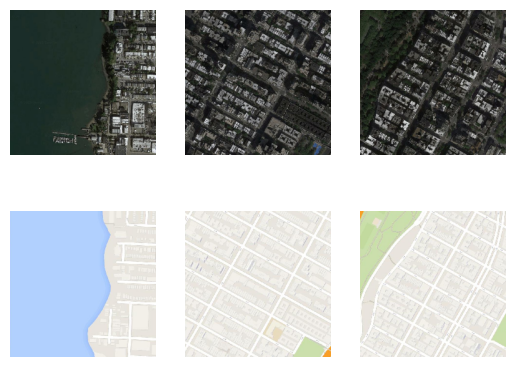

In [36]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


1/1 [==============================] - 1s 1s/step


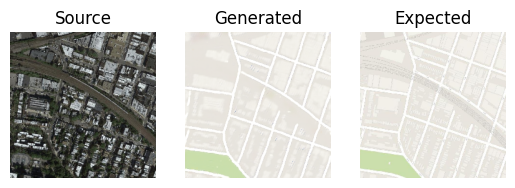

In [38]:
# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, 3, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# show title
		pyplot.title(titles[i])
	pyplot.show()

# load dataset
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('/content/drive/MyDrive/Colab Notebooks/model_043840.h5')
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)